# Analyze single cell tracks

Analyze cell motility in the osteogenic front. Input data consists of manually tracked xy-positions of individual cells, both near the front as well as in the bulk away from the front.

### Load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
cwd = os.getcwd(); print("Working dir: " + cwd)

Working dir: /Users/dang/Documents/TablerLab/Code


In [2]:
# --- Input parameters ---
video_labels = ["190305", "190314", "200120", "020917"];
pix_per_micron_all = [4.400, 5.1040, 5.1040, 4.4034]; # Number of pixels per micron
names_compare = ["Bone Front", "In Bone", "Further In Bone"];
video_image_sizes = np.array([[859.55, 655], [1099.53, 562.5], [927.51, 769.01], [1054.42, 655.50] ]); # in microns
delta_t = 1/6; # time interval between slices in hrs

In [3]:
# Load files
data_path = "/Users/dang/Documents/TablerLab/Data_Adrian_cell_tracks/";
fname_templates = ["Results from MaxProjected_Stitched_Blurred_190305 ML1 OsxGFP Explant Video 1 (0-12hr) in um per min.csv",
                  "Results from MaxProjected_Stitched_Blurred_190314 ML1 OsxGFP Explant Video 1 (0-8hr) in um per sec.csv",
                   "Results from MaxProjected_Stitched_Blurred_200120 Live Imaging OsxGFP E1375 12 hours in um per sec.csv",
                  "Results from MAX_BLUR_20200414AQR_osx_E13 in um per min.csv"]
filenames_all = [["{} {}".format(x,y) for x in names_compare] for y in fname_templates ];
N_videos = len(fname_templates);
N_files_per_video = len(names_compare);

loaded_data_all = [[None]*N_files_per_video for _ in range(N_videos)];
for i in range(N_videos):    
    subfolder = "Video {}/".format(i+1);
    for j in range(N_files_per_video):
        loaded_data_all[i][j] = pd.read_csv(data_path+subfolder+filenames_all[i][j]);

### Process data

In [4]:
# Total number of cells
N_cells_all = [ [len(np.unique(loaded_data_all[i][j].Track)) for j in range(N_files_per_video) ] for i in range(N_videos)];
print("Number of cells = " + str(N_cells_all))

# Number of slices per cell
N_slices_all = [ [len(np.unique(loaded_data_all[i][j].Slice)) for j in range(N_files_per_video)] for i in range(N_videos)];
print("Number of slices(=frames) per cell = " + str(N_slices_all))

Number of cells = [[46, 23, 36], [47, 31, 34], [52, 24, 39], [54, 39, 30]]
Number of slices(=frames) per cell = [[73, 73, 73], [49, 49, 49], [73, 73, 73], [85, 85, 85]]


In [5]:
X_all_all = [[None]*N_files_per_video for _ in range(N_videos)];
Y_all_all = [[None]*N_files_per_video for _ in range(N_videos)];
tracks_all_all = [[None]*N_files_per_video for _ in range(N_videos)];

for i1 in range(N_videos):
    pix_per_micron = pix_per_micron_all[i1];
    for i2 in range(N_files_per_video):
        loaded_data = loaded_data_all[i1][i2];
        N_cells = N_cells_all[i1][i2];
        N_slices = N_slices_all[i1][i2];
        
        # Extract X and Y coordinates for each cell
        X_all = np.nan*np.zeros([N_cells, N_slices]);
        Y_all = np.nan*np.zeros([N_cells, N_slices]);
        tracks_all = np.unique(loaded_data.Track); # Cell track numbers

        for i in range(len(tracks_all)):
            track = tracks_all[i];
            # select cell i
            data_cell_i = loaded_data.loc[loaded_data.Track == track];
            slices_cell_i = data_cell_i.Slice-1;

            # store data
            X_all[i, slices_cell_i] = data_cell_i.X;
            Y_all[i, slices_cell_i] = data_cell_i.Y; 

        X_all_all[i1][i2] = X_all;
        Y_all_all[i1][i2] = Y_all;
        tracks_all_all[i1][i2] = tracks_all;           

In [6]:
# For plotting:
slices_all_all = [ [np.array([range(N_slices_all[i1][i2]) for i in range(N_cells_all[i1][i2])])/6 
                    for i2 in range(N_files_per_video)] for i1 in range(N_videos)];
# time range to plot
t_lower = 0; # starting time in hrs
t_upper = 6; # final time in hrs
slice_range = np.arange(t_lower*6, t_upper*6); # hours*6
#slice_range = range(Nslices) #full range

# colors for categories
#colors_cats = ['gray', 'pink', 'black'];
colors_cats = [(0, 0, 0),  (1/3, 1/3, 1/3), (2/3, 2/3, 2/3)];

# system default colors
prop_cycle = plt.rcParams['axes.prop_cycle']
def_colors = prop_cycle.by_key()['color'];

# (1) Displacement profiles
Plot displacement vs time for both individual cells and averages over all tracked cells.

## Plot all 2D cell tracks
This effectively recovers the tracks as shown in the videos.

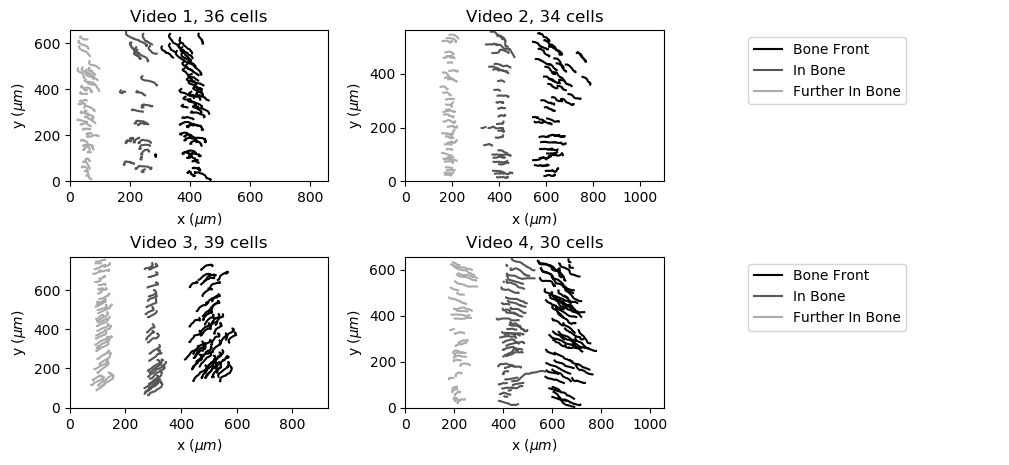

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(12, 5), dpi=100)

for i1 in range(N_videos):
    pix_per_micron = pix_per_micron_all[i1];
    [ix, iy] = divmod(i1, 2);
    for i2 in range(N_files_per_video):
        X_all = X_all_all[i1][i2];
        Y_all = Y_all_all[i1][i2];  
        N_cells = N_cells_all[i1][i2];
        
        axs[ix, iy].plot(X_all[:, slice_range].T/pix_per_micron, Y_all[:, slice_range].T/pix_per_micron, color=colors_cats[i2]);
        #this_title = 'Video {} ({}) {}, {} cells'.format(i1+1, video_labels[i1], names_compare[i2], str(N_cells));
        #this_title = 'Video {}, {}, {} cells'.format(i1+1, names_compare[i2], str(N_cells));
        this_title = 'Video {}, {} cells'.format(i1+1, str(N_cells));
        this_size = video_image_sizes[i1];
        axs[ix, iy].set(xlabel='x ($\\mu m$)', ylabel='y ($\\mu m$)', title=this_title, xlim=[0, this_size[0]], ylim=[0, this_size[1]])

plt.subplots_adjust(hspace=0.5, wspace=0.3)

# ---- Legend ----
for row in range(2):
    for i, this_label in enumerate(names_compare):
        axs[row, 2].plot(np.nan, label=this_label, color=colors_cats[i])
    axs[row, 2].legend(loc='upper left')
    axs[row, 2].axis('off')
plt.show()

## Tracked cells over time
The number of cells which are tracked typically decreases over time, because it is not possible to follow all cells until the end of the video. Hence the averages above are taken over fewer and fewer cells as time progresses, leading to larger uncertainties. Below we plot the number of tracked cells over time for reference.

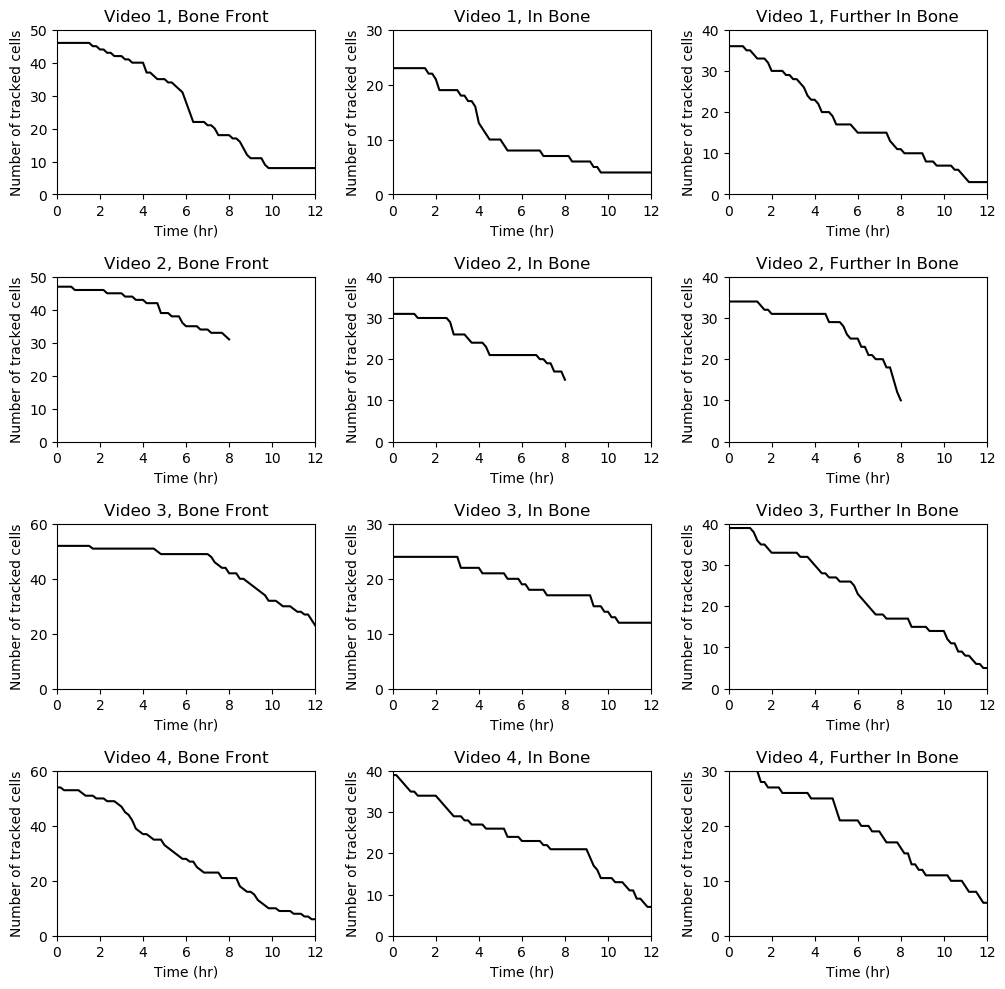

In [8]:
from math import ceil
fig, axs = plt.subplots(N_videos, N_files_per_video, figsize=(12, 12), dpi=100)
for i1 in range(N_videos):
    for i2 in range(N_files_per_video):
        X_all = X_all_all[i1][i2];
        slices_all = slices_all_all[i1][i2];
        
        N_tracked_cells_vs_t = np.sum(~np.isnan(X_all), axis=0);        
        
        axs[i1,i2].plot(slices_all[0,:], N_tracked_cells_vs_t, 'k')
        #this_title = 'Video {} ({}) {}'.format(i1+1, video_labels[i1], names_compare[i2]);
        this_title = 'Video {}, {}'.format(i1+1, names_compare[i2]);
        ylim_up = ceil(N_tracked_cells_vs_t[0]/10)*10;
        axs[i1,i2].set(xlabel='Time (hr)', ylabel='Number of tracked cells', title=this_title, xlim=[0, 12], ylim = [0, ylim_up])
        
plt.subplots_adjust(hspace=0.5, wspace=0.3)

plt.show();

## Mean-squared displacements
The mean-squared displacement of the cells in 2D is given by MSD(t) = $\sqrt{\langle [x(t) - x(0)]^2 + [y(t) - y(0)]^2 \rangle}$.

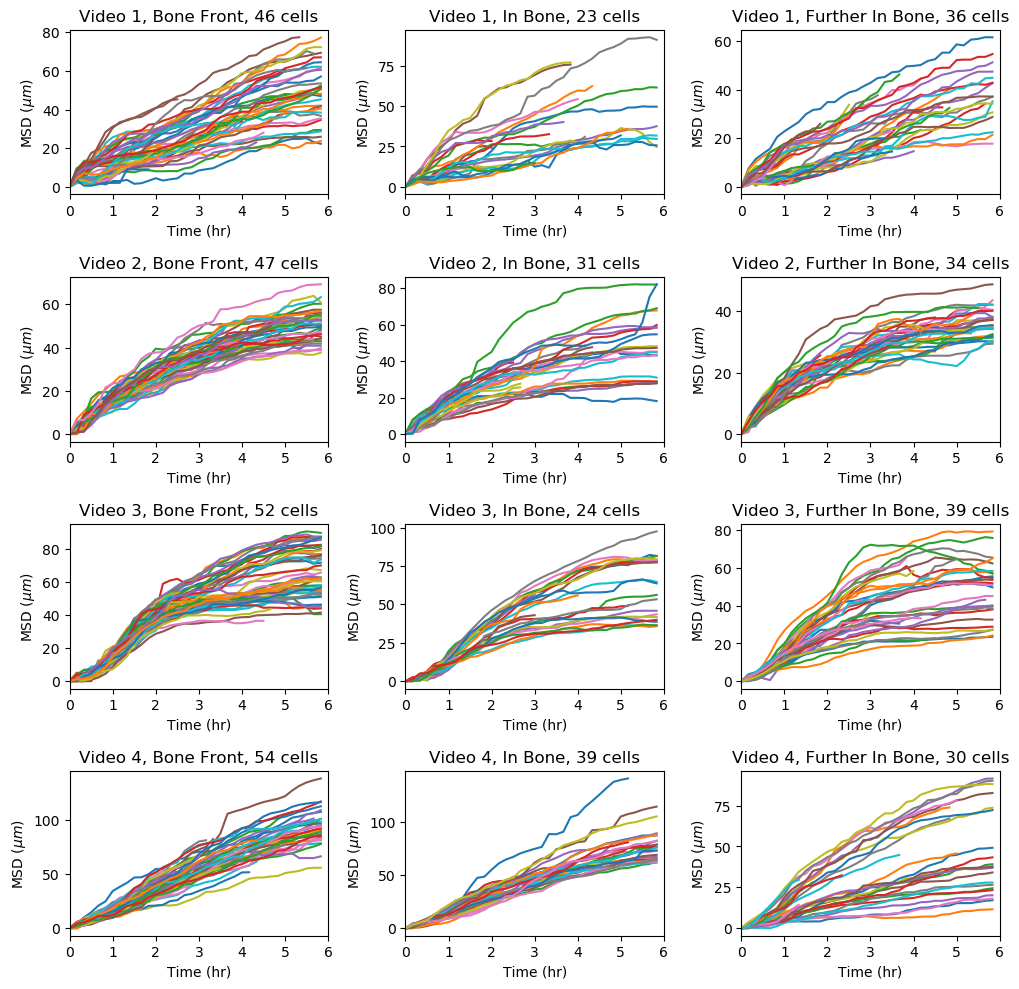

In [9]:
# Plot displacements in horizontal direction vs t
fig, axs = plt.subplots(N_videos, N_files_per_video, figsize=(12, 12), dpi=100)
for i1 in range(N_videos):
    pix_per_micron = pix_per_micron_all[i1];
    for i2 in range(N_files_per_video):
        X_all = X_all_all[i1][i2][:,slice_range];
        Y_all = Y_all_all[i1][i2][:,slice_range];
        N_cells = N_cells_all[i1][i2];
        slices_all = slices_all_all[i1][i2][:, slice_range];
        
        MSD_all = np.array(list(map( lambda X, Y: np.sqrt( (X-X[0])**2 + (Y-Y[0])**2) , X_all, Y_all)))/pix_per_micron; # units: microns

        axs[i1, i2].plot(slices_all.T, MSD_all.T)
        #this_title = 'Video {} ({}) {}, {} cells'.format(i1+1, video_labels[i1], names_compare[i2], str(N_cells));
        this_title = 'Video {}, {}, {} cells'.format(i1+1, names_compare[i2], str(N_cells));
        axs[i1, i2].set(xlabel='Time (hr)', ylabel='MSD ($\\mu m$)', title=this_title, xlim=[t_lower, t_upper])

plt.subplots_adjust(hspace=0.5, wspace=0.3)

plt.show()

Blue shaded area = standard error of the mean
Grey shaded area = standard deviation of data set


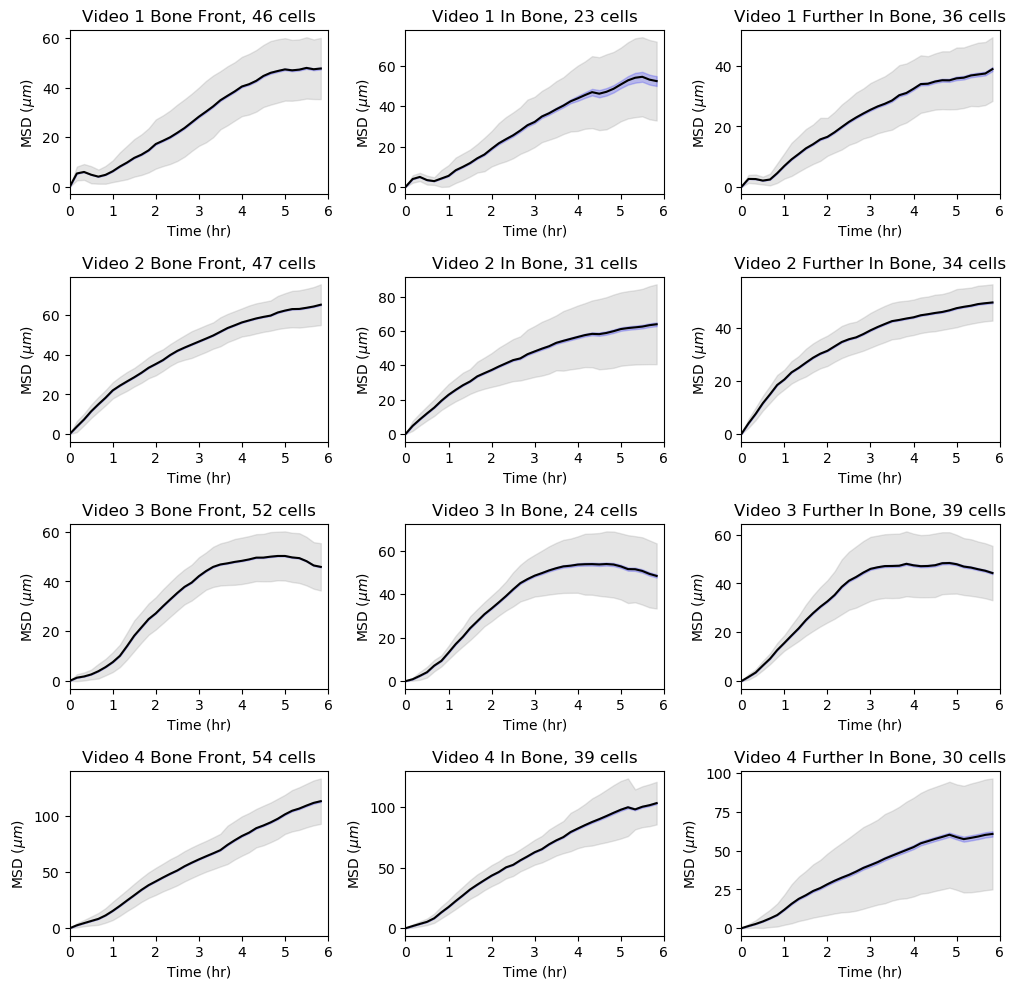

In [10]:
# --- Average over all cells ---
# store for later
MSD_avg_all = [[None]*N_files_per_video for _ in range(N_videos)];
sem_all_all = [[None]*N_files_per_video for _ in range(N_videos)];

# Plot displacements in horizontal direction vs t
fig, axs = plt.subplots(N_videos, N_files_per_video, figsize=(12, 12), dpi=100)
for i1 in range(N_videos):
    pix_per_micron = pix_per_micron_all[i1];
    for i2 in range(N_files_per_video):
        X_all = X_all_all[i1][i2][:, slice_range];
        Y_all = X_all_all[i1][i2][:, slice_range];
        N_cells = N_cells_all[i1][i2];
        slices = slices_all_all[i1][i2][0, slice_range];
        
        # Compute mean
        MSD_all = np.array(list(map( lambda X, Y: np.sqrt( (X-X[0])**2 + (Y-Y[0])**2) , X_all, Y_all)))/pix_per_micron; # units: microns
        MSD_avg = np.nanmean(MSD_all, axis=0);
        
        # Compute SEM
        std_all = np.nanstd(MSD_all, axis=0); # Std for each time point
        n_all = np.sum(~np.isnan(MSD_all), axis=0); # no. data points per time point
        sem_all = std_all/n_all;
        
        # store results
        MSD_avg_all[i1][i2] = MSD_avg;
        sem_all_all[i1][i2] = sem_all;
        
        axs[i1, i2].plot(slices, MSD_avg, color='k')
        axs[i1, i2].fill_between(slices, MSD_avg+std_all, MSD_avg-std_all, alpha=0.2, color='gray')
        axs[i1, i2].fill_between(slices, MSD_avg+sem_all, MSD_avg-sem_all, alpha=0.2, color='b')
        #this_title = 'Video {} ({}) {}, {} cells'.format(i1+1, video_labels[i1], names_compare[i2], str(N_cells));
        this_title = 'Video {} {}, {} cells'.format(i1+1, names_compare[i2], str(N_cells));
        axs[i1, i2].set(xlabel='Time (hr)', ylabel='MSD ($\\mu m$)', title=this_title, xlim=[t_lower, t_upper])

plt.subplots_adjust(hspace=0.5, wspace=0.3)

# print("Net mean velocity over {} hours = {} microns/hr".format(t_upper, round(X_displacements_avg[-1]/t_upper)) )
print("Blue shaded area = standard error of the mean")
print("Grey shaded area = standard deviation of data set")

plt.show()

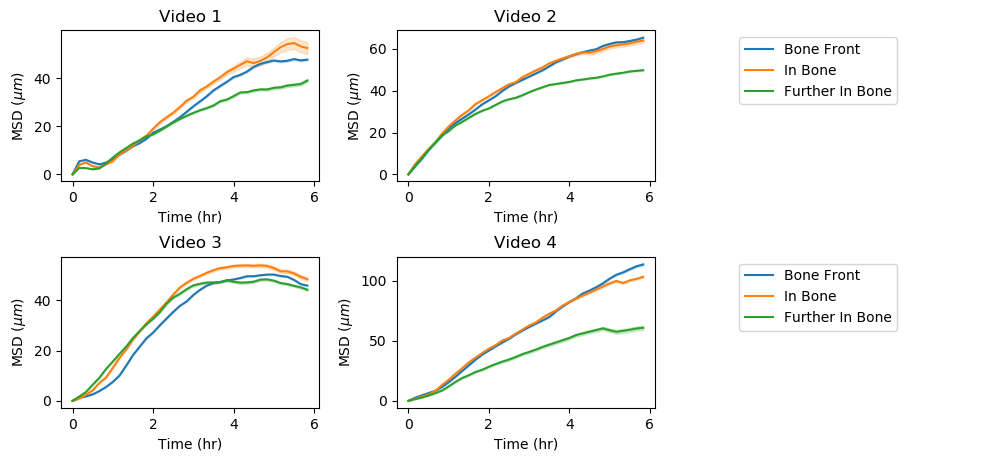

In [11]:
# --- Same data as previous plots, but now directly compare bone front and in bone ---
fig, axs = plt.subplots(2, 3, figsize=(12, 5), dpi=100);
for i1 in range(N_videos):
    [ix, iy] = divmod(i1, 2); # positions of plots
    for i2 in range(N_files_per_video):
        slices = slices_all_all[i1][i2][0, slice_range];
        
        axs[ix, iy].plot(slices, MSD_avg_all[i1][i2], label=names_compare[i2], color=def_colors[i2])
        axs[ix, iy].fill_between(slices, MSD_avg_all[i1][i2]+sem_all_all[i1][i2], MSD_avg_all[i1][i2]-sem_all_all[i1][i2], alpha=0.2, color=def_colors[i2])
    
    #axs[i1].set( title= 'Video {} ({})'.format(i1+1, video_labels[i1]), xlabel='Time (hr)', ylabel='$\\langle x(t) - x(0) \\rangle$ ($\\mu m$)'  )
    axs[ix, iy].set( title= 'Video {}'.format(i1+1), xlabel='Time (hr)', ylabel='MSD ($\\mu m$)'  )
    #axs[i1].legend();
plt.subplots_adjust(wspace=0.3)
# plt.show()
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# ---- Legend ----
#plt.figure(dpi=100, figsize = (2, 1) )
for row in range(2):
    for i, this_label in enumerate(names_compare):
        axs[row, 2].plot(np.nan, label=this_label, color=def_colors[i])
    axs[row, 2].legend(loc='upper left')
    axs[row, 2].axis('off')
plt.show()

# ---- Legend ----
# plt.figure(dpi=100, figsize = (2, 1) )
# for i, this_label in enumerate(names_compare):
#     plt.plot(np.nan, label=this_label)
# plt.axis('off')
# plt.legend()
# plt.show()

## Horizontal displacements
Shows displacement of cells relative to their initial position in the direction perpendicular to the front (horizontal). However, cells do not necessarily migrate exactly in the horizontal direction due to two factors: (1) the orientation of the front in the image is never perfectly vertical, (2) individual cells drift also in the direction perpendicular to the front. A better metric for cell motility is therefore the MSD. <br>
<a style="color:red;"> Results are basically the same as for MSD. </a>

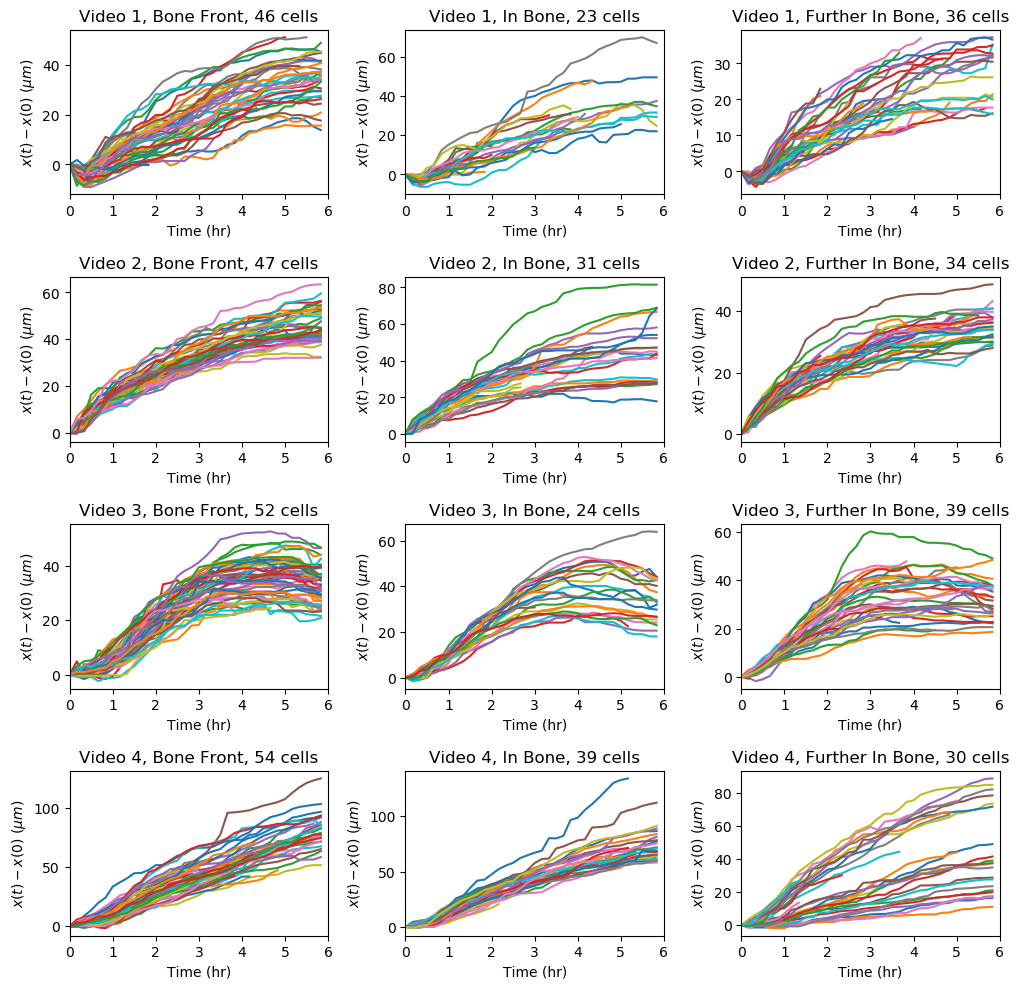

In [12]:
# Plot displacements in horizontal direction vs t
fig, axs = plt.subplots(N_videos, N_files_per_video, figsize=(12, 12), dpi=100)
for i1 in range(N_videos):
    pix_per_micron = pix_per_micron_all[i1];
    for i2 in range(N_files_per_video):
        X_all = X_all_all[i1][i2][:,slice_range];
        N_cells = N_cells_all[i1][i2];
        slices_all = slices_all_all[i1][i2][:,slice_range];
        
        X_displacements = np.array(list(map(lambda x: x-x[0], X_all)))/pix_per_micron; # units: microns
        
        axs[i1, i2].plot(slices_all.T, X_displacements.T)
        #this_title = 'Video {} ({}) {}, {} cells'.format(i1+1, video_labels[i1], names_compare[i2], str(N_cells));
        this_title = 'Video {}, {}, {} cells'.format(i1+1, names_compare[i2], str(N_cells));
        axs[i1, i2].set(xlabel='Time (hr)', ylabel='$x(t) - x(0)$ ($\\mu m$)', title=this_title, xlim=[t_lower, t_upper])

plt.subplots_adjust(hspace=0.5, wspace=0.3)

plt.show()

Blue shaded area = standard error of the mean
Grey shaded area = standard deviation of data set


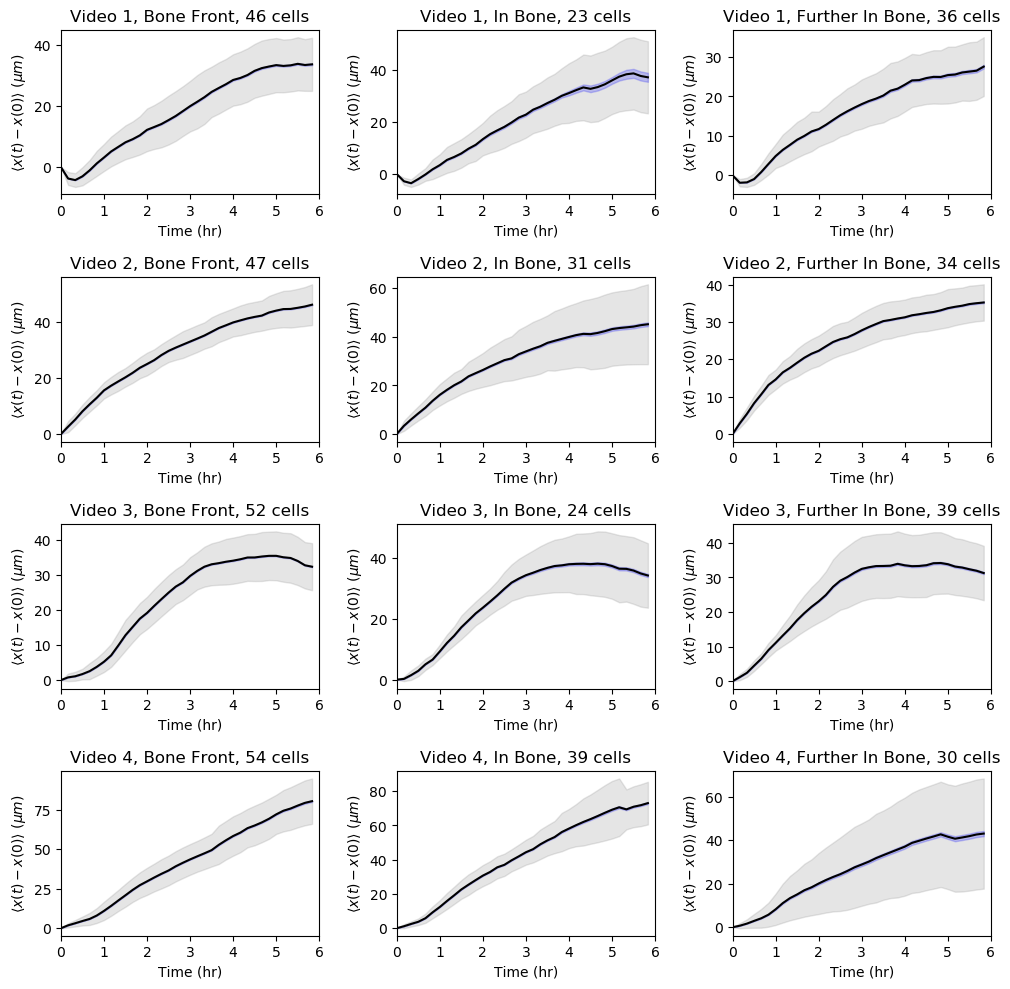

In [13]:
# --- Average over all cells ---
# Store for later 
X_displacements_avg_all = [[None]*N_files_per_video for _ in range(N_videos)];
sem_all_all = [[None]*N_files_per_video for _ in range(N_videos)];

# Plot displacements in horizontal direction vs t
fig, axs = plt.subplots(N_videos, N_files_per_video, figsize=(12, 12), dpi=100)
for i1 in range(N_videos):
    pix_per_micron = pix_per_micron_all[i1];
    for i2 in range(N_files_per_video):
        X_all = X_all_all[i1][i2][:,slice_range];
        N_cells = N_cells_all[i1][i2];
        slices = slices_all_all[i1][i2][0, slice_range];
        
        # Compute mean
        X_displacements = np.array(list(map(lambda x: x-x[0], X_all)))/pix_per_micron; # units: microns
        X_displacements_avg = np.nanmean(X_displacements, axis=0);
        
        # Compute SEM
        std_all = np.nanstd(X_displacements, axis=0); # Std for each time point
        n_all = np.sum(~np.isnan(X_displacements), axis=0); # no. data points per time point
        sem_all = std_all/n_all;
        
        axs[i1, i2].plot(slices, X_displacements_avg, 'k')
        axs[i1, i2].fill_between(slices, X_displacements_avg+std_all, X_displacements_avg-std_all, alpha=0.2, color='gray')
        axs[i1, i2].fill_between(slices, X_displacements_avg+sem_all, X_displacements_avg-sem_all, alpha=0.2, color='b')
        #this_title = 'Video {} ({}) {}, {} cells'.format(i1+1, video_labels[i1], names_compare[i2], str(N_cells));
        this_title = 'Video {}, {}, {} cells'.format(i1+1, names_compare[i2], str(N_cells));
        axs[i1, i2].set(xlabel='Time (hr)', ylabel='$\\langle x(t) - x(0) \\rangle$ ($\\mu m$)', title=this_title, xlim=[t_lower, t_upper])
        
        # store results
        X_displacements_avg_all[i1][i2] = X_displacements_avg;
        sem_all_all[i1][i2] = sem_all;
        
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# print("Net mean velocity over {} hours = {} microns/hr".format(t_upper, round(X_displacements_avg[-1]/t_upper)) )
print("Blue shaded area = standard error of the mean")
print("Grey shaded area = standard deviation of data set")

plt.show()

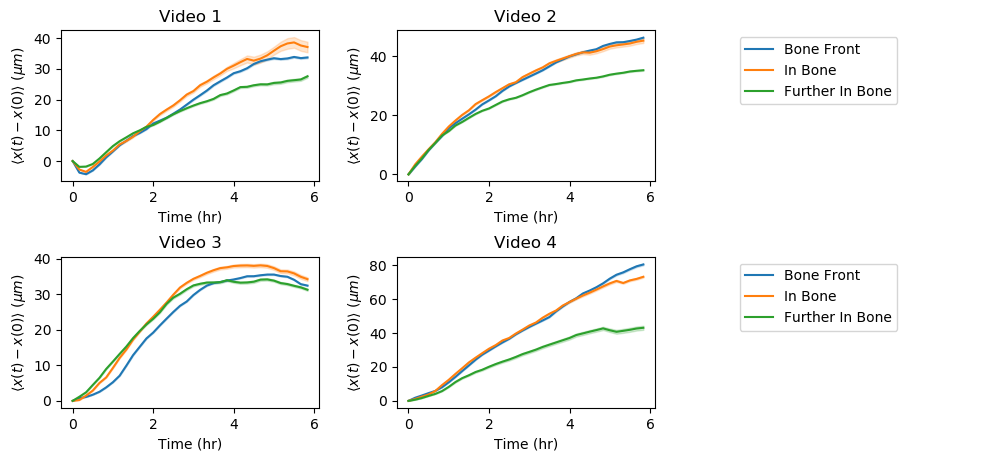

In [14]:
# --- Summary plots: compare locations with each other ---
fig, axs = plt.subplots(2, 3, figsize=(12, 5), dpi=100);

for i1 in range(N_videos):
    [ix, iy] = divmod(i1, 2); # positions of plots
    for i2 in range(N_files_per_video):
        slices = slices_all_all[i1][i2][0, slice_range];
        axs[ix, iy].plot(slices, X_displacements_avg_all[i1][i2], label=names_compare[i2], color=def_colors[i2])
        axs[ix, iy].fill_between(slices, X_displacements_avg_all[i1][i2]+sem_all_all[i1][i2], X_displacements_avg_all[i1][i2]-sem_all_all[i1][i2], alpha=0.2, color=def_colors[i2])
    
    #this_title='Video {} ({})'.format(i1+1, video_labels[i1]);
    this_title='Video {}'.format(i1+1);
    
    axs[ix, iy].set( title= this_title, xlabel='Time (hr)', ylabel='$\\langle x(t) - x(0) \\rangle$ ($\\mu m$)'  )
    #axs[i1].legend();
    
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# ---- Legend ----
#plt.figure(dpi=100, figsize = (2, 1) )
for row in range(2):
    for i, this_label in enumerate(names_compare):
        axs[row, 2].plot(np.nan, label=this_label, color=def_colors[i])
    axs[row, 2].legend(loc='upper left')
    axs[row, 2].axis('off')

plt.show()
#plt.figure(dpi=100, figsize = (2, 1) )
# for i, this_label in enumerate(names_compare):
#     plt.plot(np.nan, label=this_label)
# plt.axis('off')
# plt.legend()
# plt.show()

In [15]:
# Save analyzed displacement profiles for comparison
save_folder = "/Users/dang/Documents/TablerLab/Data_Adrian_cell_tracks/";
for i1 in range(N_videos):
    for i2 in range(N_files_per_video):
        video_label = video_labels[i1];
        name_label = names_compare[i2];
        
        data_out = np.array([X_displacements_avg_all[i1][i2], sem_all_all[i1][i2]])
        
        fname_out = "Analyze_single_cell_tracks_X_displacements_avg_all_video_{}_{}_{}.csv".format(i1+1, video_label, name_label);
        X_displacements_out = pd.DataFrame(data_out.T, columns=["mean_displacement", "SEM"]);
        #X_displacements_out.to_csv(save_folder + fname_out)        

# (2) Persistence of cell motion

Do cells in the front move more persistently (i.e. along the same direction) than cells in the bulk?

### Approach 1: "Fraction of efficient movement"
Define persistence as the ratio between the net displacement (i.e. distance between initial and final position of a cell) and the total displacement (i.e. total length of path travelled). 
This is related to but different from the approach in <a href = "https://www.nature.com/articles/ncb1762#Sec27"> Simpson et al., 2008 </a>.

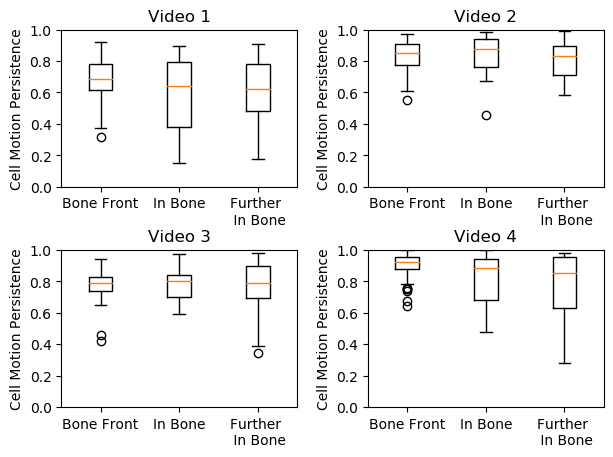

In [16]:
persistences_all_all = np.array([[None]*N_files_per_video for _ in range(N_videos)]);
labels_all = np.array([[None]*N_files_per_video for _ in range(N_videos)]);

names_compare_2 = ["Bone Front", "In Bone", "Further \n In Bone"];

fig, axs = plt.subplots(2, 2, figsize=(7, 5), dpi=100)

for i1 in range(N_videos):
    [ix, iy] = divmod(i1, 2)
    for i2 in range(N_files_per_video):
        X_all = X_all_all[i1][i2];
        Y_all = Y_all_all[i1][i2];
        N_cells = N_cells_all[i1][i2];

        # calculate total displacement
        del_X_all = np.array(list(map(np.diff, X_all))); # X[t+1]-X[t] for all cells
        del_Y_all = np.array(list(map(np.diff, Y_all))); # Y[t+1]-Y[t] for all cells
        displacements_all = np.nansum( np.sqrt(del_X_all**2 + del_Y_all**2) , axis=1 );

        # calculate net displacement
        net_displacements_all = np.zeros(N_cells);
        for i in range(N_cells):
            X_t = X_all[i, :]; 
            Y_t = Y_all[i, :];
            dX = X_t[~np.isnan(X_t)][-1]-X_t[~np.isnan(X_t)][0]; # X(t_final) - X(t_initial)
            dY = Y_t[~np.isnan(Y_t)][-1]-Y_t[~np.isnan(Y_t)][0]; # Y(t_final) - Y(t_initial)
            net_displacements_all[i] = np.sqrt(dX**2 + dY**2);

        persistences_all_all[i1][i2] = net_displacements_all/displacements_all;
        labels_all[i1][i2] = '{}'.format(names_compare_2[i2]);
                
    # Plot figure
    axs[ix, iy].boxplot(persistences_all_all[i1,:], labels=labels_all[i1,:]);   
    axs[ix, iy].set(ylim=[0,1], title='Video {}'.format(i1+1) ); 
    axs[ix, iy].set(ylabel='Cell Motion Persistence');

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show();



### Approach 2: velocity correlation functions
This should give a time scale up to which cells maintain their direction.

The velocity autocorrelation function is $C_{VV}(t, t') = \langle v(t) v(t') \rangle$, 
where $\langle \ldots \rangle$ is an ensemble-average over all cells. <br>
Typically we set $t'=0$ and measure correlations with the velocity at the initial time. However, note that the results may depend on the $t'$ chosen, because we do not expect time-invariance, under which $C_{VV}(t, t')$ would be a function of $|t-t'|$ only. <br>
Recall that $C_{VV}(t, t')$ decays exponentially for Brownian motion. <br>
Note that $C_{VV}(t, t')$ is unnormalized, but can be normalized to give Pearson correlation coefficients.

In [18]:
# ---- TO DO: NORMALIZE ALL VELOCITIES! -------
#v_temp_norm = velocities_all[i_cell]/np.array(list(map(np.linalg.norm, v_temp))).reshape(len(v_temp), 1);
#list(map(np.linalg.norm, v_temp))
#velocities_all[i_cell]/np.array(list(map(np.linalg.norm, v_temp))); 

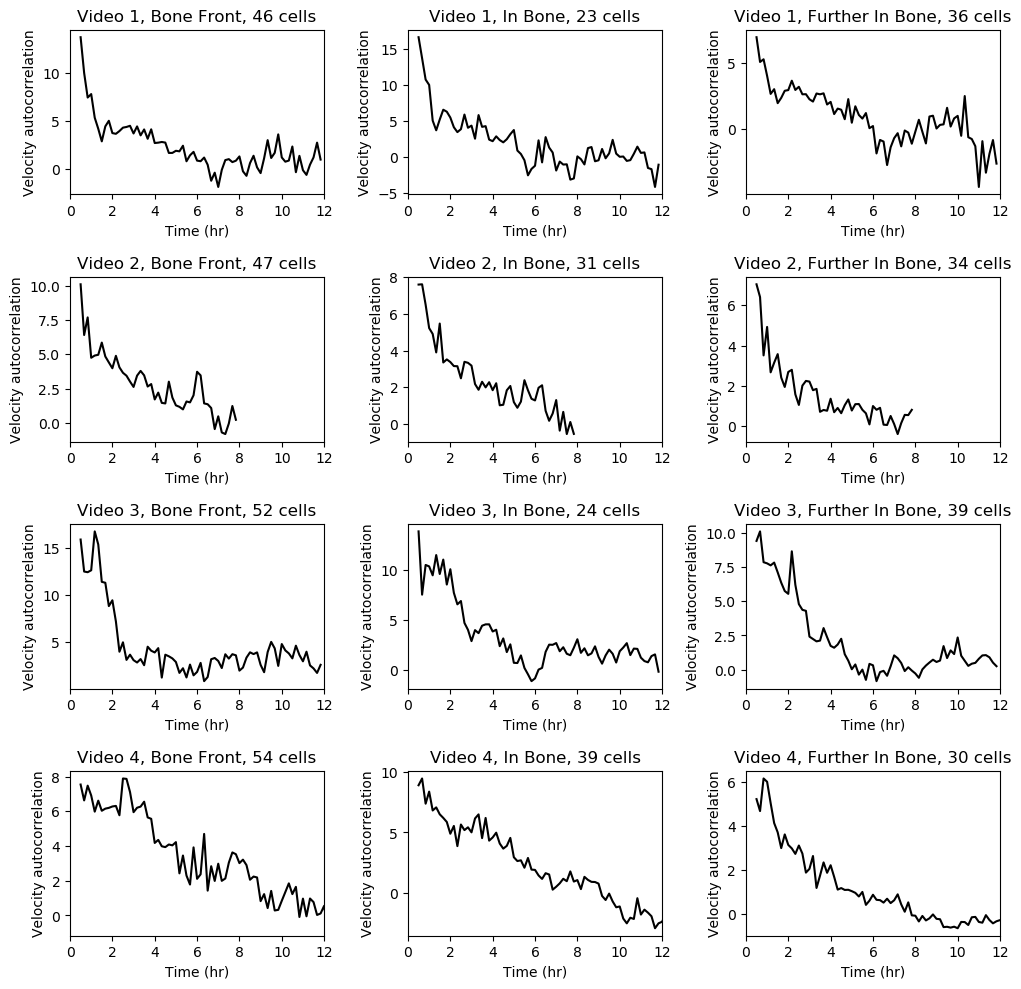

All velocities are relative to the "initial" velocity at time = 0.5 hrs


In [19]:
fig, axs = plt.subplots(N_videos, N_files_per_video, figsize=(12, 12), dpi=100)
for i1 in range(N_videos):
    pix_per_micron = pix_per_micron_all[i1];
    for i2 in range(N_files_per_video):
        X_all = X_all_all[i1][i2];
        Y_all = Y_all_all[i1][i2];
        N_cells = N_cells_all[i1][i2];
        N_slices = N_slices_all[i1][i2];
        slices_all = slices_all_all[i1][i2];        
        
        # calculate velocities
        del_X_all = np.array(list(map(np.diff, X_all))); # X[t+1]-X[t] for all cells
        del_Y_all = np.array(list(map(np.diff, Y_all))); # Y[t+1]-Y[t] for all cells
        velocities_all = np.swapaxes( np.swapaxes( np.array([del_X_all, del_Y_all])/pix_per_micron, 0, 1), 1, 2); # units: microns

        # calculate autocorrelation
        t_init = 3; # initial time to correlate with
 
        correlations_all = np.zeros([N_cells, N_slices-t_init-1])*np.nan;
        for i_cell in range(velocities_all.shape[0]):  
            v_temp = velocities_all[i_cell]; # no normalization            # 
            # v_temp = velocities_all[i_cell]/np.array(list(map(np.linalg.norm, v_temp))); #normalize all velocities to norm 1
            
            correlations_all[i_cell, :] = np.dot(v_temp[t_init:], v_temp[t_init]); # normalized
            
        correlation_func = np.nanmean(correlations_all, axis=0);

        axs[i1, i2].plot(slices_all[0, t_init:-1], correlation_func, 'k')
        #this_title = 'Video {} ({}) {}, {} cells'.format(i1+1, video_labels[i1], names_compare[i2], str(N_cells));
        this_title = 'Video {}, {}, {} cells'.format(i1+1, names_compare[i2], str(N_cells));
        axs[i1, i2].set(xlabel='Time (hr)', ylabel='Velocity autocorrelation', title=this_title, xlim=[t_lower, 12])

plt.subplots_adjust(hspace=0.5, wspace=0.33)

plt.show()
print('All velocities are relative to the "initial" velocity at time = {} hrs'.format(round(t_init/6, 3)))


# (3) Spatial correlations
How do correlations between cell motions depend on the spatial locations and distances between cells? <br>
## <a style="color:red;"> Everything below = unfinished, in progress </a>

### Pairwise distance statistics

First we analyse the distribution of all pairwise distances of the tracked cells. <br>

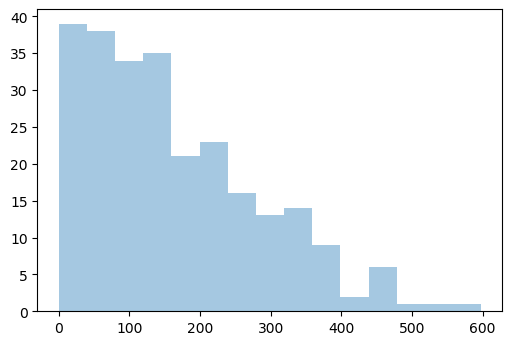

In [20]:
i1=0;
i2=1;
t=2;

X_all = X_all_all[i1][i2][:, t];
Y_all = Y_all_all[i1][i2][:, t];
# pairwise distances between cells
incl_self = 0; # include self-pairs of the form [i,i]?
# loop j over range(i+1) to include self-pairs, or range(i) to exclude self-pairs
X_all_paired = np.array([ [X_all[i], X_all[j]] for i in range(len(X_all)) for j in range(i+incl_self)]);
Y_all_paired = np.array([ [X_all[i], X_all[j]] for i in range(len(X_all)) for j in range(i+incl_self)]);
def f(x, y):
    return np.sqrt((x[0]-x[1])**2 + (y[0]-y[1])**2)
pairwise_dist_all = np.array(list(map(f, X_all_paired, Y_all_paired )) );

# -- Verify that this yields the pair-wise elements of an array --
# data_all = np.array([[i, j] for i in range(10) for j in range(i+1)]).T;
# plt.scatter( data_all[0], data_all[1]  )
plt.figure(dpi=100)
plt.hist(pairwise_dist_all, bins=15, alpha = 0.4)
plt.show()

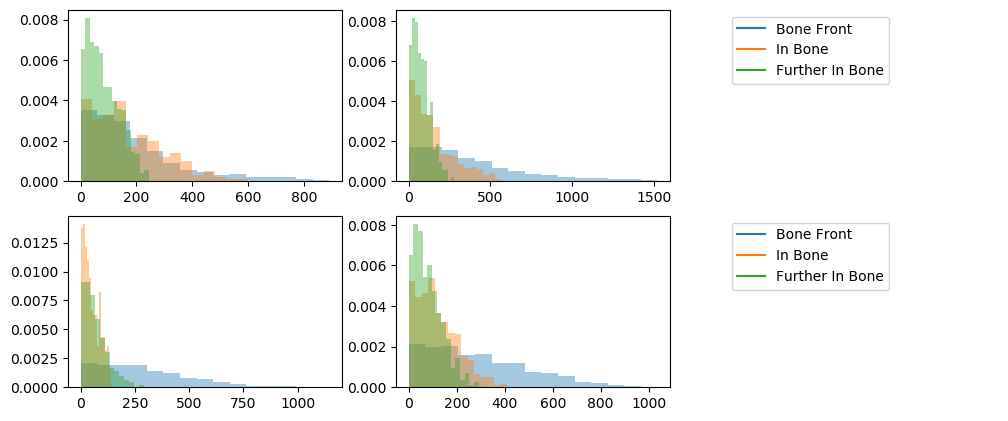

In [21]:
# i1=0;
# i2=0;
t=0;

fig, axs = plt.subplots(2, 3, figsize=(12, 5), dpi=100)
for i1 in range(N_videos):
    [ix, iy] = divmod(i1, 2)
    for i2 in range(N_files_per_video):
        X_all = X_all_all[i1][i2][:, t];
        Y_all = Y_all_all[i1][i2][:, t];
        # pairwise distances between cells
        incl_self = 0; # include self-pairs of the form [i,i]?
        # loop j over range(i+1) to include self-pairs, or range(i) to exclude self-pairs
        X_all_paired = np.array([ [X_all[i], X_all[j]] for i in range(len(X_all)) for j in range(i+incl_self)]);
        Y_all_paired = np.array([ [X_all[i], X_all[j]] for i in range(len(X_all)) for j in range(i+incl_self)]);
        def f(x, y):
            return np.sqrt((x[0]-x[1])**2 + (y[0]-y[1])**2)
        pairwise_dist_all = np.array(list(map(f, X_all_paired, Y_all_paired )) );

        axs[ix, iy].hist(pairwise_dist_all, bins=15, alpha = 0.4, density=True)
        
# --- legend ---
for row in range(2):
    for i, this_label in enumerate(names_compare):
        axs[row, 2].plot(np.nan, label=this_label)
    axs[row, 2].legend(loc='upper left')
    axs[row, 2].axis('off')

### Spatial velocity correlations
Define $C_{VV}(x_i, x_j) = \langle v(x_i, t) v(x_j, t) \rangle$ as the spatial correlation function of cell velocities. Assume $C_{VV}(x_i, x_j) = C_{VV}(x_i-x_j)$ and average over cells with the same distance (in practice, bin together pairs of cells that have similar distance to each other). 

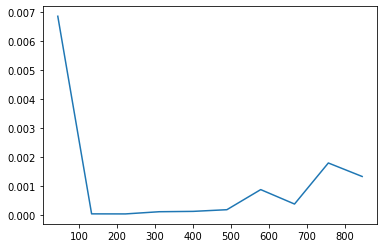

In [22]:
i1=0;
i2=0;
t=0;

X_all = X_all_all[i1][i2][:, t];
Y_all = Y_all_all[i1][i2][:, t];
# pairwise distances between cells
incl_self = 0; # include self-pairs of the form [i,i]?
# loop j over range(i+1) to include self-pairs, or range(i) to exclude self-pairs
X_all_paired = np.array([ [X_all[i], X_all[j]] for i in range(len(X_all)) for j in range(i+incl_self)]);
Y_all_paired = np.array([ [X_all[i], X_all[j]] for i in range(len(X_all)) for j in range(i+incl_self)]);
pair_idx = np.array([ [i, j] for i in range(len(X_all)) for j in range(i+incl_self)]); # pair indices

def f(x, y):
    return np.sqrt((x[0]-x[1])**2 + (y[0]-y[1])**2)
pairwise_dist_all = np.array(list(map(f, X_all_paired, Y_all_paired )) );

hist, edges = np.histogram(pairwise_dist_all);

compare_bin_edges = np.array([pairwise_dist_all[i] <= edges for i in range(len(pairwise_dist_all))]);
bin_idx = np.array(list(map( np.argmax, compare_bin_edges))); # indices of the bins of all the data

# calculate velocities (optimize later)
del_X_all = np.array(list(map(np.diff, X_all_all[i1][i2] ))); # X[t+1]-X[t] for all cells
del_Y_all = np.array(list(map(np.diff, Y_all_all[i1][i2] ))); # Y[t+1]-Y[t] for all cells
velocities_all = np.swapaxes( np.swapaxes( np.array([del_X_all, del_Y_all])/pix_per_micron, 0, 1), 1, 2); # units: microns
this_velocities_all = velocities_all[:, t, :];



corr_v_all = np.zeros(len(edges)-1); # correlation function
for i in range(len(edges)-1):
    #print( np.sum ( bin_idx==i ) ) 
    this_idx = np.argwhere(bin_idx==i); # indices that fall in bin i
    #print(pair_idx[this_idx])
    temp = pair_idx[this_idx];
    for j in range(len(temp)):
        idx1=pair_idx[this_idx][j][0][0];
        idx2=pair_idx[this_idx][j][0][1];
        v1 = this_velocities_all[idx1];
        v2 = this_velocities_all[idx2];
        corr_v_all[i] = np.inner( v1, v2 )/np.inner(v1, v1)/np.inner(v2, v2);
    
    corr_v_all[i] = corr_v_all[i]/len(temp);               

bincenters = (edges[1:]+edges[:-1])/2

plt.figure()
plt.plot(bincenters, corr_v_all)
plt.show()

In [23]:
        v1 = this_velocities_all[idx1];
        v2 = this_velocities_all[idx2];
        np.inner( v1, v2 )/np.inner(v1, v1)/np.inner(v2, v2)

0.018751715285374955

In [24]:
temp = pair_idx[this_idx];
for i in range(len(temp)):
    
    idx1=pair_idx[this_idx][i][0][0];
    idx2=pair_idx[this_idx][i][0][1];
    
    this_velocities_all[idx1]*this_velocities_all[idx2]


### Test

In [25]:
import random 
test_data = np.array([random.uniform(1, 10) for _ in range(10)]); #np.array([0, 1, 9])
test_data

array([6.05163289, 6.16988945, 4.14170618, 5.29907829, 5.61764669,
       1.3323363 , 3.87823487, 7.14822638, 4.68196475, 3.46342881])

In [26]:
[p for i, p in enumerate(test_data) ]

[6.051632887584999,
 6.169889452572367,
 4.141706178956465,
 5.299078285721925,
 5.617646694717761,
 1.3323363020752625,
 3.878234872792973,
 7.148226375134387,
 4.681964752732946,
 3.46342881335122]

In [27]:
edges = np.array(range(10));
temp = [p <= edges for i, p in enumerate(test_data) ];
temp

[array([False, False, False, False, False, False, False,  True,  True,
         True]),
 array([False, False, False, False, False, False, False,  True,  True,
         True]),
 array([False, False, False, False, False,  True,  True,  True,  True,
         True]),
 array([False, False, False, False, False, False,  True,  True,  True,
         True]),
 array([False, False, False, False, False, False,  True,  True,  True,
         True]),
 array([False, False,  True,  True,  True,  True,  True,  True,  True,
         True]),
 array([False, False, False, False,  True,  True,  True,  True,  True,
         True]),
 array([False, False, False, False, False, False, False, False,  True,
         True]),
 array([False, False, False, False, False,  True,  True,  True,  True,
         True]),
 array([False, False, False, False,  True,  True,  True,  True,  True,
         True])]

In [28]:
bin_idx = np.array(list(map( np.argmax, temp)));
bin_idx

array([7, 7, 5, 6, 6, 2, 4, 8, 5, 4])

In [29]:
bin_idx==0

array([False, False, False, False, False, False, False, False, False,
       False])

In [30]:
corr_v_all = np.zeros(len(edges)-1);

for i in range(len(edges)-1):
    print( np.sum( bin_idx==i ) ) 
    this_idx = np.argwhere(bin_idx==i);
    print(this_idx)    
    corr_v_all[i] = np.sum( test_data[this_idx]  )

0
[]
0
[]
1
[[5]]
0
[]
2
[[6]
 [9]]
2
[[2]
 [8]]
2
[[3]
 [4]]
2
[[0]
 [1]]
1
[[7]]


In [31]:
edges[:-1]+edges[1:]

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17])

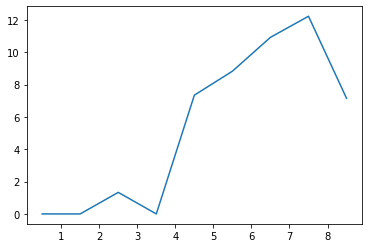

In [32]:
bincenters = (edges[1:]+edges[:-1])/2
plt.plot(bincenters, corr_v_all)